# Profiling report

This notebook processes the profiling records that were generated by `$REPO_ROOT/profiler.sh`,
computes aggregate statistics
and generates plots to be used for further analysis.

Results are exported to `$REPO_ROOT/reports/nb`.

In [1]:
import os
import json
import git
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import datetime
from scipy import stats
PARENT_DIR_REPORTS = './reports/nb/'
REPORT_TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
DIR_REPORT = os.path.join(PARENT_DIR_REPORTS, REPORT_TIMESTAMP)
os.makedirs(DIR_REPORT, exist_ok=True)
DIR_REPORT

'./reports/nb/2023-11-22T17:00:01'

In [2]:
def get_repo_info():    
    repo = git.Repo(path='.')
    return {
        'head': repo.head.commit.__str__(),
        'branch': repo.active_branch.__str__()
    }


## Input data

In [3]:
records = dict(
    map(
        lambda fpath: (fpath, pd.Series(json.loads(open(fpath, 'r').read()), name=fpath)),
        glob('./reports/profiling/*.json')
    )
)
len(records)

200

In [4]:
series = pd.concat(records)
series.index.get_level_values(0).unique().shape
df = series.unstack()
df.index.set_names('fpath',inplace=True)
df.reset_index(inplace=True)
df['actor'] = df.fpath.apply(os.path.basename).str.split('-').apply(lambda x: x[0])
df.index.set_names('idx_report',inplace=True)
df.rename({'start':'start_report','end':'end_report','delta':'delta_report'},axis=1,inplace=True)
display(df.head())
df.shape

,fpath,actor,records,start_report,end_report,delta_report
idx_report,,,,,,
0,./reports/profiling/DidVCActor-1700610500120.json,DidVCActor,"[{'index': 0, 'name': 'createCredential', 'sta...",1700610500120,1700610501242,1122
1,./reports/profiling/SolidVCActor-1700607587662...,SolidVCActor,"[{'index': 0, 'name': 'createCredential', 'sta...",1700607587662,1700607588524,862
2,./reports/profiling/DidVCActor-1700609188100.json,DidVCActor,"[{'index': 0, 'name': 'createCredential', 'sta...",1700609188100,1700609189109,1009
3,./reports/profiling/SolidVCActor-1700609593120...,SolidVCActor,"[{'index': 0, 'name': 'createCredential', 'sta...",1700609593120,1700609593976,856
4,./reports/profiling/SolidVCActor-1700608693561...,SolidVCActor,"[{'index': 0, 'name': 'createCredential', 'sta...",1700608693561,1700608694350,789


(200, 6)

## Analysis

In [5]:
AGG_FUNCTIONS = ['mean', 'std', 'min','max','count']

### Actor-level statistics

In [6]:
df_agg_al = df.groupby('actor')['delta_report'].agg(AGG_FUNCTIONS)
df_agg_al

,mean,std,min,max,count
actor,,,,,
DidVCActor,1116.24,101.671000,988,1543,100
SolidVCActor,877.25,79.855852,768,1116,100


Compute & export aggregate statistics

In [7]:
df_agg_al.to_csv(os.path.join(DIR_REPORT, 'df_agg_actor-level.csv'))

### Task-level statistics

In [8]:
# Expand report records into task-level dataframes
df_tl = df.records\
    .apply(pd.Series)\
    .stack()\
    .apply(pd.Series)\
    .rename({'index':'idx_step'},axis=1)\
    .reset_index().drop('level_1',axis=1)\
    .set_index(['idx_report','idx_step'])
# Merge task-level df with initial df
df_tl = df.drop('records',axis=1).merge(df_tl,left_index=True,right_index=True)
display(df_tl.head(3))
df_tl.shape

fpath  \
idx_report idx_step                                                      
0          0         ./reports/profiling/DidVCActor-1700610500120.json   
           1         ./reports/profiling/DidVCActor-1700610500120.json   
           2         ./reports/profiling/DidVCActor-1700610500120.json   

                          actor   start_report     end_report delta_report  \
idx_report idx_step                                                          
0          0         DidVCActor  1700610500120  1700610501242         1122   
           1         DidVCActor  1700610500120  1700610501242         1122   
           2         DidVCActor  1700610500120  1700610501242         1122   

                                           name          start            end  \
idx_report idx_step                                                             
0          0                   createCredential  1700610500120  1700610500121   
           1         createVerifiableCredential  1700610500121  1700610500144   
           2                  createJSONLDFrame  1700610500144  1700610500145   

                     delta  
idx_report idx_step         
0          0             1  
           1            23  
           2             1

(1400, 9)

Compute & export aggregate statistics

In [9]:
# name refers to the function/step name
df_tl_agg = df_tl.groupby(['actor','name'])['delta'].agg(AGG_FUNCTIONS)
df_tl_agg.to_csv(os.path.join(DIR_REPORT, 'df_agg_task-level.csv'))

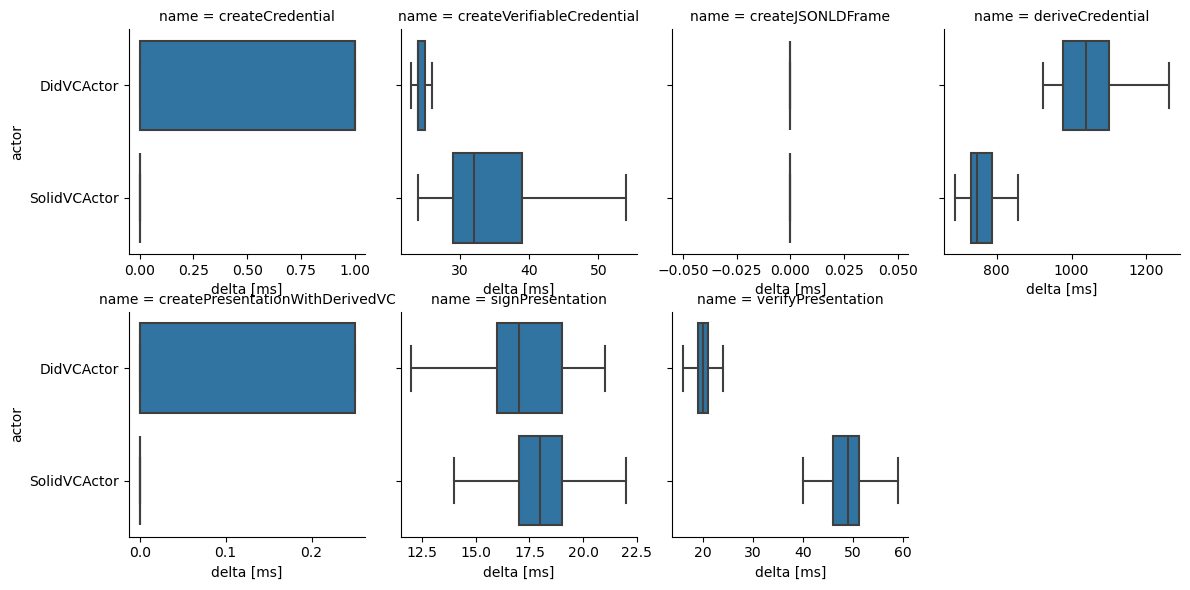

In [10]:
kwargs_fg = dict(col = 'name',  col_wrap=4, sharey=True,sharex=False,aspect=1)
kwargs_plot = dict(
    x='delta',
    y='actor',
    orient='h',
    showfliers=False,
)
g = sns.FacetGrid(**kwargs_fg, data=df_tl)
g.map_dataframe(sns.boxplot, **kwargs_plot)
#g.tight_layout()
#g.fig.subplots_adjust(top=1.1)

for ax in g.axes.ravel():
    ax.set_xlabel('{} [ms]'.format(kwargs_plot['x']))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    pass

plt.savefig(os.path.join(DIR_REPORT,'boxplot-actor-on-delta-per-step.png'),pad_inches=.5)
plt.show()

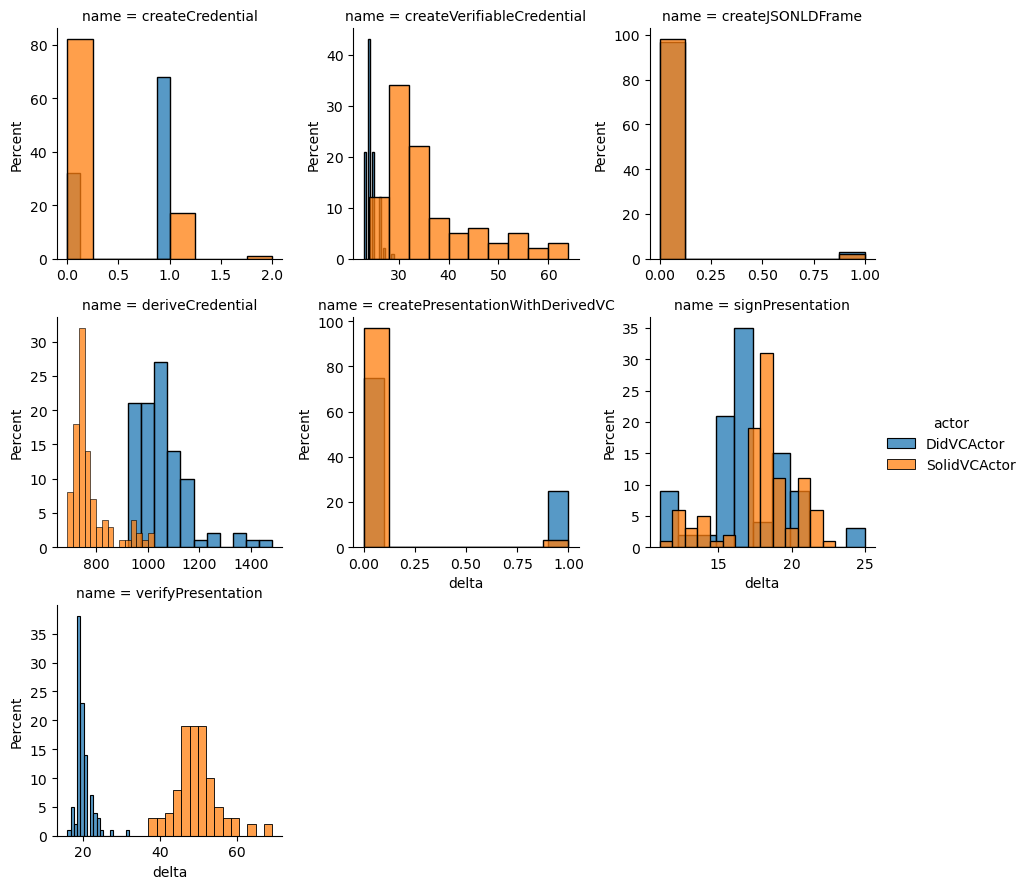

In [11]:
kwargs_fg = dict(col = 'name',  col_wrap=3, sharey=False,sharex=False, legend_out=True,    hue='actor',)
kwargs_plot = dict(
    x='delta',
    stat='percent',
    element='bars',
    discrete=False,
#    common_norm=True

)
g = sns.FacetGrid(**kwargs_fg, data=df_tl)
g = g.map_dataframe(sns.histplot, **kwargs_plot)
for ax in g.axes.ravel():
    pass

g.add_legend()
plt.savefig(os.path.join(DIR_REPORT,'barplot-actor-on-percentage-delta-per-step.png'))
plt.show()

In [12]:
get_repo_info()
json.dump(get_repo_info(), open(os.path.join(DIR_REPORT,'repo-info.json'), 'w'))

## Statistics

In [13]:
df__verify_vp = df_tl[df_tl.name == 'verifyPresentation']
df__verify_vp

,,fpath,actor,start_report,end_report,delta_report,name,start,end,delta
idx_report,idx_step,,,,,,,,,
0,6,./reports/profiling/DidVCActor-1700610500120.json,DidVCActor,1700610500120,1700610501242,1122,verifyPresentation,1700610501215,1700610501242,27
1,6,./reports/profiling/SolidVCActor-1700607587662...,SolidVCActor,1700607587662,1700607588524,862,verifyPresentation,1700607588461,1700607588524,63
2,6,./reports/profiling/DidVCActor-1700609188100.json,DidVCActor,1700609188100,1700609189109,1009,verifyPresentation,1700609189089,1700609189109,20
3,6,./reports/profiling/SolidVCActor-1700609593120...,SolidVCActor,1700609593120,1700609593976,856,verifyPresentation,1700609593925,1700609593976,51
4,6,./reports/profiling/SolidVCActor-1700608693561...,SolidVCActor,1700608693561,1700608694350,789,verifyPresentation,1700608694303,1700608694350,47
...,...,...,...,...,...,...,...,...,...,...
195,6,./reports/profiling/DidVCActor-1700611238518.json,DidVCActor,1700611238518,1700611239677,1159,verifyPresentation,1700611239655,1700611239677,22
196,6,./reports/profiling/SolidVCActor-1700610003578...,SolidVCActor,1700610003578,1700610004578,1000,verifyPresentation,1700610004520,1700610004578,58
197,6,./reports/profiling/DidVCActor-1700608369121.json,DidVCActor,1700608369121,1700608370234,1113,verifyPresentation,1700608370215,1700608370234,19


### Significance testing

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [14]:
p_thresh = .05

In [15]:
steps = df_tl.name.unique()
print(steps)

['createCredential' 'createVerifiableCredential' 'createJSONLDFrame'
 'deriveCredential' 'createPresentationWithDerivedVC' 'signPresentation'
 'verifyPresentation']


In [16]:

grpr_actor = df_tl.groupby('actor')
assert grpr_actor.ngroups == 2
A,B = grpr_actor

Reminder

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [17]:
_var = 'delta'
ttr_ind_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

for step_name in steps:
        a = df_a[df_a.name == step_name][_var].values.tolist()
        b = df_b[df_b.name == step_name][_var].values.tolist()
        assert np.shape(a) == np.shape(b)
        ttr_ind_per_step[step_name]=stats.ttest_ind(a,b)
        
df_test_results = pd.Series(ttr_ind_per_step).apply(lambda t: t._asdict()).apply(pd.Series)
df_test_results.rename({'statistic': 'tvalue'}, axis=1,inplace=True)
# Add flag to indicate whether to accept/reject H0
df_test_results['REJECT_H0'] = df_test_results.pvalue < p_thresh
df_test_results

,tvalue,pvalue,df,_alternative,_standard_error,_estimate,REJECT_H0
createCredential,7.791979,3.643591e-13,198.0,0.0,0.062885,0.49,True
createVerifiableCredential,-11.604675,4.335052e-24,198.0,0.0,0.946170,-10.98,True
createJSONLDFrame,0.450872,6.525753e-01,198.0,0.0,0.022179,0.01,False
deriveCredential,22.173697,1.478622e-55,198.0,0.0,12.596005,279.30,True
createPresentationWithDerivedVC,4.703391,4.792127e-06,198.0,0.0,0.046775,0.22,True
signPresentation,-1.925122,5.564705e-02,198.0,0.0,0.368808,-0.71,False
verifyPresentation,-48.678138,3.959136e-112,198.0,0.0,0.602324,-29.32,True


In [18]:
df__verify_vp.groupby('actor')

In [19]:
steps_with_sig_diff = df_test_results[df_test_results.REJECT_H0].index
print(steps_with_sig_diff)

Index(['createCredential', 'createVerifiableCredential', 'deriveCredential',
       'createPresentationWithDerivedVC', 'verifyPresentation'],
      dtype='object')


In [20]:
df_tl_sig_diff = df_tl[df_tl.name.apply(lambda n: n in steps_with_sig_diff)]
df_tl_sig_diff.shape

(1000, 9)

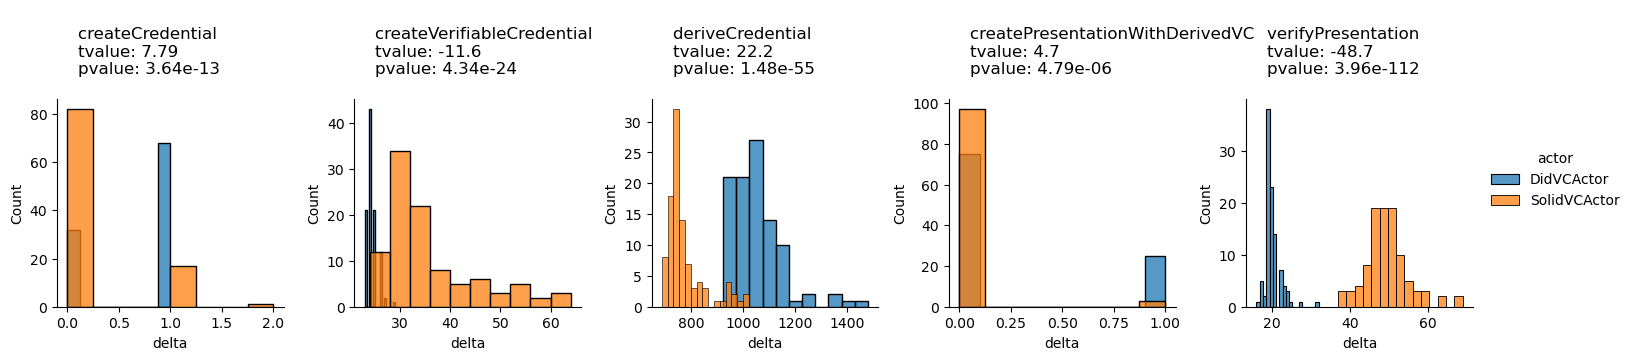

In [21]:
g = sns.FacetGrid(df_tl_sig_diff,col='name',legend_out=True, hue='actor',sharex=False, sharey=False)

g = g.map_dataframe(sns.histplot, x='delta',)
g.add_legend()

for c in g.col_names:
    s = df_test_results.loc[c]

    g.axes_dict[c].set_title('',loc='center')
    txt_stats = f'''
    {c}
    tvalue: {s["tvalue"]:.3}
    pvalue: {s["pvalue"]:.3}
    '''
    g.axes_dict[c].set_title(txt_stats,loc='left')

### Effect size

#### Cohen's d

$$
d = \frac{\bar x_1 - \bar x_2}{s}
$$

|Effect size|	d|
|-----------|----|
|Very small	|0.01|
|Small		|0.20|
|Medium		|0.50|
|Large		|0.80|
|Very large	|1.20|
|Huge		|2.00|

In [22]:
from numpy import var, mean, sqrt

def cohend(d1: pd.Series, d2: pd.Series) -> float:

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)

    # return the effect size
    return (u1 - u2) / s

In [23]:
_var = 'delta'
effect_size_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

for step_name in steps:
        a = df_a[df_a.name == step_name][_var]
        b = df_b[df_b.name == step_name][_var]
        effect_size_per_step[step_name] = cohend(a,b)
        
s_effect_sizes = pd.Series(effect_size_per_step, name=f'cohend_{k_a}_{k_b}')

df_effect_sizes = s_effect_sizes.to_frame()
def cohend_effect_class(d: float) -> str:
    d = np.abs(d)
    if d >= 2.0:
        return 'HUGE'
    if d >= 1.2:
        return 'VERY_LARGE'
    if d >= 0.8:
        return 'LARGE'
    if d >= 0.5:
        return 'MEDIUM'
    if d >= 0.2:
        return 'SMALL'
    if d > 0.01:
        return 'VERY_SMALL'
    return 'NIHIL'

df_effect_sizes['effect_class'] = s_effect_sizes.apply(cohend_effect_class)
df_effect_sizes

,cohend_DidVCActor_SolidVCActor,effect_class
createCredential,1.101952,LARGE
createVerifiableCredential,-1.641149,VERY_LARGE
createJSONLDFrame,0.063763,VERY_SMALL
deriveCredential,3.135834,HUGE
createPresentationWithDerivedVC,0.665160,MEDIUM
signPresentation,-0.272253,SMALL
verifyPresentation,-6.884128,HUGE


In [24]:
df_effect_sizes.to_csv(os.path.join(DIR_REPORT, 'df_effect_sizes.csv'))

# Appendix

## Statsmodels

In [25]:
?stats.ttest_ind

Signature:
stats.ttest_ind(
    a,
    b,
    axis=0,
    equal_var=True,
    nan_policy='propagate',
    permutations=None,
    random_state=None,
    alternative='two-sided',
    trim=0,
    *,
    keepdims=False,
)
Docstring:
Calculate the T-test for the means of *two independent* samples of scores.

This is a test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have identical variances by default.

Parameters
----------
a, b : array_like
    The arrays must have the same shape, except in the dimension
    corresponding to `axis` (the first, by default).
axis : int or None, default: 0
    If an int, the axis of the input along which to compute the statistic.
    The statistic of each axis-slice (e.g. row) of the input will appear in a
    corresponding element of the output.
    If ``None``, the input will be raveled before computing the statistic.
equal_var : bool, optional
    If True (default), pe